In [42]:
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [43]:
TRAIN_DATA_PATH = "./data-collection/train/"
TEST_DATA_PATH = "./data-collection/test/"
TRANSFORM_IMG = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )
    ])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)

In [54]:
torch.bincount(torch.tensor(train_data.targets))

tensor([ 3236,  2811,  8572, 13500])

In [55]:
torch.bincount(torch.tensor(test_data.targets))

tensor([ 360,  312,  952, 1500])

In [44]:
BATCH_SIZE = 20
LEARNING_RATE = 0.01

In [45]:
train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
test_data_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 
img =next(iter(train_data_loader))
img[0].shape

torch.Size([20, 1, 28, 28])

In [46]:
class cnn_first(nn.Module):
    
    # Contructor
    def __init__(self, out_1=8, out_2=16, out_3=128):
        super(cnn_first, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(out_2 * 7 * 7, out_3)
        self.bn_fc1 = nn.BatchNorm1d(out_3)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.bn_fc1(x)
        
        return x

class cnn_second(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32, out_3=128):
        super(cnn_second, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(out_2 * 7 * 7, out_3)
        self.bn_fc1 = nn.BatchNorm1d(out_3)
        
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.bn_fc1(x)
        
        return x

class lstm_block(nn.Module):
    
    def __init__(self, in_channels=128, hidden_dim=64,hidden_dim2=32, num_payers=2, out_channels=4):
        super(lstm_block, self).__init__()
        
        self.lstm1 = nn.LSTM(in_channels, hidden_dim, num_payers, batch_first=True, dropout = 0.4)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim2, num_payers, batch_first=True, dropout = 0.4)
        
        self.fc1 = nn.Linear(hidden_dim2, out_channels)
        
    def forward(self, x):
        x = x.view(x.size(0), 1, -1)
        out, hn = self.lstm1(x)
        out, hn2 = self.lstm2(out)
        
        out = self.fc1(out[:, -1, :])
        
        return out

In [47]:
def train_model(model1, model2,model3, n_epochs,train_loader,validation_loader,optimizer1, optimizer2, optimizer3):
    
    #global variable 
    N_test=len(test_data)
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        total_loss = 0
        count = 0
        for x, y in train_loader:
            model1.train()
            model2.train()
            model3.train()
            
            optimizer1.zero_grad()
            out1 = model1(x)
            loss1 = criterion(out1, y)
            loss1.backward(retain_graph=True)
            optimizer1.step()
            
            optimizer2.zero_grad()
            out2 = model1(x)
            loss2 = criterion(out2, y)
            loss2.backward(retain_graph=True)
            optimizer2.step()
            
            
            out = out1+out2
            optimizer3.zero_grad()
            z = model3(out)
            loss3 = criterion(z, y)
            loss3.backward(retain_graph=True)
            optimizer3.step()
            total_loss += loss3.item()
            
        loss_list.append(total_loss/len(train_loader))
        

        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            model1.eval()
            model2.eval()
            model3.eval()
            z1 = model1(x_test)
            z2 = model2(x_test)
            z = z1+z2
            z = model3(z)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        print('Epoch: ', epoch, 'Loss: ', total_loss/len(train_loader), 'Accuracy: ', accuracy)
     
    return accuracy_list, loss_list

In [48]:
# Create the model object using CNN class
model1 = cnn_first(out_1=8, out_2=16, out_3=128)
model2 = cnn_second(out_1=16, out_2=32, out_3=128)
model3 = lstm_block(in_channels=128, hidden_dim=64,hidden_dim2=32, num_payers=2, out_channels=4)

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr = LEARNING_RATE, momentum=0.6)
optimizer2 = torch.optim.SGD(model2.parameters(), lr = LEARNING_RATE, momentum=0.6)
optimizer3 = torch.optim.SGD(model3.parameters(), lr = LEARNING_RATE, momentum=0.6)

In [50]:
accuracy_list_normal, loss_list_normal=train_model(model1, model2,model3,n_epochs=10,
                                                   train_loader=train_data_loader,
                                                   validation_loader=test_data_loader,optimizer1=optimizer1,
                                                  optimizer2=optimizer2, optimizer3=optimizer3)
print('Finished')

Epoch:  0 Loss:  1.2047915189483258 Accuracy:  0.4801536491677337
Epoch:  1 Loss:  1.1909830258631944 Accuracy:  0.4801536491677337
Epoch:  2 Loss:  1.1590620545964492 Accuracy:  0.4801536491677337
Epoch:  3 Loss:  0.6618955806957539 Accuracy:  0.7765685019206146
Epoch:  4 Loss:  0.42259625982424276 Accuracy:  0.8882842509603073
Epoch:  5 Loss:  0.3281763154075376 Accuracy:  0.8892445582586428
Epoch:  6 Loss:  0.28432240004877785 Accuracy:  0.910371318822023
Epoch:  7 Loss:  0.2593910077117797 Accuracy:  0.926056338028169
Epoch:  8 Loss:  0.24017343081661088 Accuracy:  0.9321382842509603
Epoch:  9 Loss:  0.22085084479731398 Accuracy:  0.9372599231754162
Finished


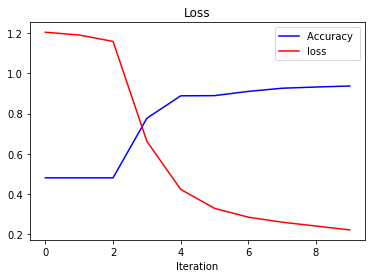

In [51]:
# Plot the loss and accuracy
plt.plot(accuracy_list_normal, 'b', label='Accuracy ')
plt.plot(loss_list_normal, 'r', label='loss')
plt.xlabel('Iteration')
plt.title("Loss")
plt.legend()